# Titanic: Train/Test Split, Cross-Validation, and Logistic Regression

This notebook explains how data is split into train and test sets, what cross-validation is
and why it's important, then builds a logistic regression pipeline for the Titanic dataset.
The final section contains a short set of student exercises to solidify learning.

# 1. Logistic Regression

**What it is:** A statistical model used for classification problems (not regression, despite the name).

**How it works:**

- Estimates the probability that a data point belongs to a class using the sigmoid (logistic) function.
- Output is between 0 and 1.
- If probability ≥ threshold (default 0.5) → class 1, otherwise class 0.

**Why we use it in Titanic dataset:** To predict if a passenger survived (binary outcome: 0 or 1).

**Key benefit:** Simple, interpretable, and a strong baseline for classification tasks.

# 2. Cross Validation (CV)

**What it is:** A method to check how well a model generalizes to unseen data.

**How it works:**

- Data is split into multiple folds (say 5 or 10).
- The model is trained on (k-1) folds and tested on the remaining fold.
- This process repeats until every fold has been used as test data once.
- Average performance is calculated.

**Why important:**
- Avoids overfitting to a single train-test split.
- Gives a more reliable estimate of model performance.

# 3. Overfitting

**What it is:**
When a model learns too much detail (including noise or random fluctuations) from the training data, so it performs very well on training but poorly on unseen/test data.

**Analogy:**
Imagine memorizing answers to past exam questions word-for-word instead of learning the underlying concepts. You’ll ace the practice questions but struggle with new ones.

**Why it happens:**

- Model is too complex (e.g., deep tree with many splits).
- Not enough data to generalize.
- Too many irrelevant features (noise).

**Symptoms:**

- Very high training accuracy but much lower test accuracy.
- Cross-validation scores vary a lot between folds.

**How to reduce it:**

- Use simpler models or apply regularization.
- Collect more training data.
- Use cross-validation to tune hyperparameters.
- Drop irrelevant features (feature selection).

## What is scikit-learn (sklearn) — and what is a Pipeline?

### scikit-learn (sklearn)
- **scikit-learn** is a very popular Python library for machine learning.  
- It provides easy-to-use tools for:
  - preprocessing data (imputing missing values, scaling, encoding),
  - training many kinds of models (logistic regression, decision trees, random forests, etc.),
  - evaluating models (cross-validation, metrics), and
  - searching for good hyperparameters (GridSearchCV / RandomizedSearchCV).  
- scikit-learn follows a simple and consistent **estimator API**:
  - `fit(X, y)` — learn from training data, producing model parameters,
  - `predict(X)` — make predictions,
  - `predict_proba(X)` — (for classifiers) return class probabilities,
  - `transform(X)` — (for transformers) return a transformed version of X,
  - `fit_transform(X, y)` — shorthand to fit then transform.

---

### What is a `Pipeline` and why use it?
A **Pipeline** chains multiple processing steps into a single object. Each step is either:
- a **transformer** (has `fit` and `transform`) — e.g., `SimpleImputer`, `StandardScaler`, `OneHotEncoder`, or  
- an **estimator** (has `fit` and `predict`) — e.g., `LogisticRegression`, `DecisionTreeClassifier`.

**Why pipelines are useful (big benefits):**
1. **Cleaner code.** You write preprocessing + model once and treat it like a single object.  
2. **No data leakage.** When you `fit` the pipeline on the training set, transformers compute statistics (mean, median, etc.) only from the training data — those same fitted transformers are then applied to the test data. This prevents accidentally leaking information from test into training.  
3. **Works with cross-validation and GridSearchCV.** You can pass the whole pipeline to `cross_val_score` or `GridSearchCV`. This makes sure preprocessing is done inside each fold correctly.  
4. **Easier hyperparameter tuning.** You can tune preprocessing or model hyperparameters via one `param_grid` by using step names (see example below).


In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, RocCurveDisplay, precision_score, recall_score, f1_score)

sns.set(style='whitegrid')

# Load Titanic dataset from seaborn (convenient for classroom use)
titanic = sns.load_dataset('titanic')
print("Columns available:", titanic.columns.tolist())

titanic.head()

Columns available: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Quick data preparation (select a small, teachable feature set)
We'll use: `pclass`, `sex`, `age`, `sibsp`, `parch`, `fare`, `embarked`. Target: `survived`.

In [2]:
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']
target = 'survived'

df = titanic[features + [target]].copy()
print("Rows before dropping NA (for demonstration):", df.shape[0])
df.sample(5)

Rows before dropping NA (for demonstration): 891


,pclass,sex,age,sibsp,parch,fare,embarked,survived
105,3,male,28.0,0,0,7.8958,S,0
580,2,female,25.0,1,1,30.0000,S,1
465,3,male,38.0,0,0,7.0500,S,0
473,2,female,23.0,0,0,13.7917,C,1
438,1,male,64.0,1,4,263.0000,S,0


## 1) Train / Test Split
**Why split?** To measure generalization, avoid overfitting. Stratified split preserves class balance.

In [4]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Train target distribution:", y_train.value_counts(normalize=True))
print("Test target distribution:", y_test.value_counts(normalize=True))

Train size: (712, 7)
Test size: (179, 7)
Train target distribution: survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64
Test target distribution: survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


## 2) K fold Cross-Validation (CV)
Cross-validation splits the training set into k folds. Each fold acts as validation once.
StratifiedKFold preserves class proportions.

### What is StratifiedKFold?
🔹 The Problem

When we use cross-validation, we split the dataset into several folds (e.g. 5 or 10 parts).
Each fold is used once as a test set while the others are used for training.

However, if the dataset is imbalanced (for example, in the Titanic dataset there are fewer survivors than non-survivors), a normal KFold split might put too many survivors in one fold and too few in another.

That would make the model’s accuracy vary a lot between folds — not a fair test of performance.

🔹 The Solution → StratifiedKFold

**StratifiedKFold is a special kind of K-Fold cross-validation that keeps the class distribution the same in every fold.**

In other words:

Each fold has roughly the same ratio of survivors and non-survivors as the original dataset.

This gives a more reliable and stable estimate of how well your model performs.

#### Visual Example (Titanic Dataset)

Let’s say in the Titanic dataset:

- 65% passengers didn’t survive (y=0)
- 35% passengers survived (y=1)

When using StratifiedKFold(n_splits=5), each of the 5 folds will also maintain about 65:35 ratio between 0s and 1s.

If you used plain KFold, some folds might accidentally have 80% non-survivors and 20% survivors, leading to biased evaluation.

In [5]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print(skf)

StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## 3) Preprocessing + Logistic Regression Pipeline
We build a ColumnTransformer + Pipeline to preprocess numeric/categorical features and train LogisticRegression.

### Why We Need Scaling?

Different features often have different units and ranges:

- Age might range from 0 to 80
- Fare might range from 0 to 500

Even though both are numeric, the Fare values are much larger.
This can confuse many machine learning algorithms (like Logistic Regression, KNN, SVM), which assume all features are on a comparable scale.

So, we standardize them to make them “look similar” numerically — without changing what they represent.

### How StandardScaler Works?

The StandardScaler transforms each numeric column separately using this formula:

$z = \frac{x - mean}{standard deviation}$


So for each feature:

- It finds the mean (average) value.
- Subtracts the mean from each data point (centers it around 0).
- Divides by the standard deviation (spreads it so typical values are around -1 to +1).

#### Example

| Passenger | Age | Fare |
|------------|-----|------|
| A | 20 | 50 |
| B | 40 | 100 |
| C | 60 | 200 |

For each column separately:

Age column: mean = 40, std = 20

New values: (20−40)/20 = −1, (40−40)/20 = 0, (60−40)/20 = +1

Fare column: mean = 116.7, std = 62.3

New values: (50−116.7)/62.3 = −1.07, (100−116.7)/62.3 = −0.27, (200−116.7)/62.3 = +1.34

After scaling:

| Passenger | Age_scaled | Fare_scaled |
|------------|-------------|--------------|
| A | −1.0 | −1.07 |
| B | 0.0 | −0.27 |
| C | +1.0 | +1.34 |


Both columns now have mean ≈ 0 and standard deviation ≈ 1,
so neither dominates the model just because it had larger numbers.

In [6]:
numeric_features = ['age', 'sibsp', 'parch', 'fare', 'pclass']
categorical_features = ['sex', 'embarked']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8044692737430168


## Understanding Model Evaluation: Confusion Matrix, ROC, AUC, and Cross-Validation

Once we have trained our logistic regression model, we need to know **how well it performs** on unseen data.  
Different evaluation metrics help us understand this from different angles.

---

### 🔹 Confusion Matrix
A **confusion matrix** summarizes how many predictions were correct and how many were wrong.

|                | **Predicted Positive (1)** | **Predicted Negative (0)** |
|----------------|-----------------------------|-----------------------------|
| **Actual Positive (1)** | True Positive (TP) ✅ | False Negative (FN) ❌ |
| **Actual Negative (0)** | False Positive (FP) ❌ | True Negative (TN) ✅ |

- **TP (True Positive):** Model correctly predicts a positive case (e.g., survived and predicted survived).  
- **TN (True Negative):** Model correctly predicts a negative case (e.g., did not survive and predicted did not survive).  
- **FP (False Positive):** Model wrongly predicts positive when it is actually negative.  
- **FN (False Negative):** Model wrongly predicts negative when it is actually positive.

From these, we can calculate:
- **Accuracy** = (TP + TN) / (TP + TN + FP + FN)  
- **Precision** = TP / (TP + FP) — out of all predicted positives, how many were correct  
- **Recall (Sensitivity)** = TP / (TP + FN) — out of all actual positives, how many were caught  

---

### 🔹 ROC Curve (Receiver Operating Characteristic)
- The **ROC Curve** shows how well the model separates the two classes (e.g., survived vs not survived).  
- It is a graph between:
  - **True Positive Rate (Recall)** on the Y-axis, and  
  - **False Positive Rate (1 - Specificity)** on the X-axis.
- The curve is drawn by changing the decision threshold (e.g., 0.5 → 0.4 → 0.3 etc.) and checking how TPR and FPR change.

Example:
- At threshold 0.5 → Model predicts “1” if probability ≥ 0.5  
- At threshold 0.3 → Model predicts “1” if probability ≥ 0.3  
  This catches more positives (higher recall) but may increase false positives.

---

### 🔹 AUC (Area Under the Curve)
- **AUC** = Area under the ROC curve.
- It summarizes the ROC curve into one number between **0** and **1**:
  - **AUC = 1.0** → perfect classifier  
  - **AUC = 0.5** → random guessing (no skill)
- A **higher AUC** means the model is better at distinguishing between the two classes.


## 4) Evaluate with ROC AUC and Cross-Validation

ROC AUC: 0.8437417654808959


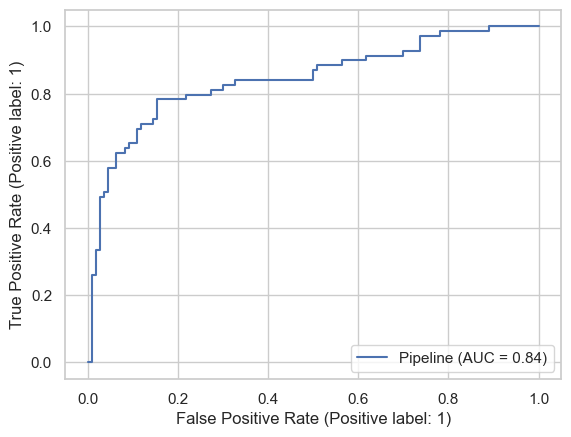

CV scores: [0.7972028  0.7972028  0.80985915 0.74647887 0.83098592]
Mean CV: 0.7963459076135132


In [7]:
probas = pipe.predict_proba(X_test)[:,1]
print('ROC AUC:', roc_auc_score(y_test, probas))

RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.show()

cv_scores = cross_val_score(pipe, X_train, y_train, cv=skf, scoring='accuracy')
print('CV scores:', cv_scores)
print('Mean CV:', cv_scores.mean())

## 5) Student Exercises
- Compute precision, recall, F1 on the test set.
- Plot confusion matrix as a heatmap and interpret.
- Compare LogisticRegression with DecisionTreeClassifier (max_depth=3).